# SET UP

In [1]:
import os
import warnings

warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 20, 8

import math
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.stattools import adfuller


from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly as py
import plotly.io as pio
import plotly.graph_objs as go
from plotly.subplots import make_subplots


from models import * 
from utils import * 

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

In [2]:
def up_sampler(dataset,upsampling_freq):
    resample_dict = dict() 
    resample_dict['ID'] = "last"
    resample_dict['Water Level'] = "last"
    resampled = (dataset.resample(f"{upsampling_freq}min",
                    kind="period",
                    convention="end",
                )
                .agg(resample_dict))
    return resampled

# Data pre-processing

In [43]:
data = pd.read_csv('data/hydro/Daily__Dec-16-2020_11_05_11PM.csv')
data = pd.DataFrame( columns = data.index[0] , data = np.vstack(data.index[1:]))
datetime_series = pd.to_datetime(data['Date'])
datetime_index = pd.DatetimeIndex(datetime_series.values)
data.set_index(datetime_index,inplace =True)
data.drop('Date',1,inplace =True)
data = data[data.index > '2000-01-01']

In [45]:
def add_nans(x): 
    if x == 'nan' : 
        return np.nan 
    else : 
        return x 
    
data['Value'] =  data['Value'].apply(add_nans)
data.isnull().sum() / data.shape[0]  

 ID      0.000000
PARAM    0.000000
Value    0.333655
dtype: float64

# EDA 

In [16]:
data['ID'].nunique()

146

There are 146 hydrometric station in our dataset 

In [13]:
data["Water Level"].isnull().sum()

0

No missing values

In [3]:
hydro.drop(hydro[hydro["Water Level / Niveau d'eau (m)"]==99999.009].index , inplace =True ) 
hydro["Water Level"] = hydro["Water Level / Niveau d'eau (m)"]
hydro["Date"] = pd.to_datetime(hydro["Date"])
hydro = hydro[["Date","Water Level"]]

## Stationarity 

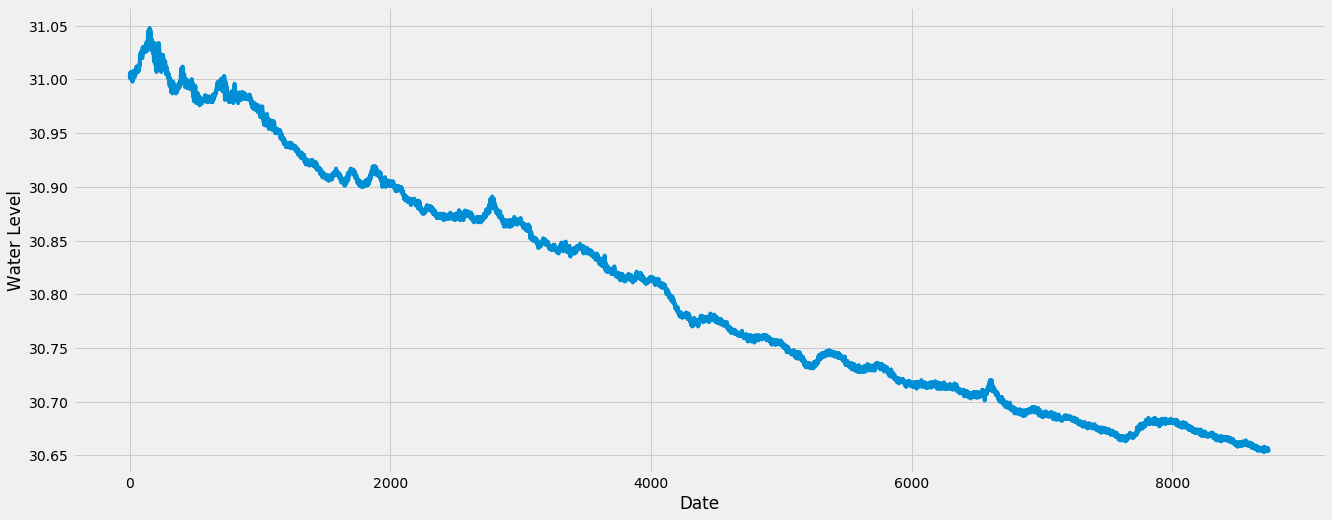

In [4]:
plt.xlabel("Date")
plt.ylabel("Water Level")
plt.plot(hydro["Water Level"])
plt.show()

in the time series forecasting, we search usually for a stationary series. The series should have a constant mean, variance, and covariance.

so let's check if the  Water Level series is stationary or not. to do this i will use ADF (Augmented Dickey-Fuller) Test :

* Null Hypothesis: The series has a unit root
* Alternate Hypothesis: The series has no unit root.


If we fail to reject the null hypothesis, we can say that the series is non-stationary.

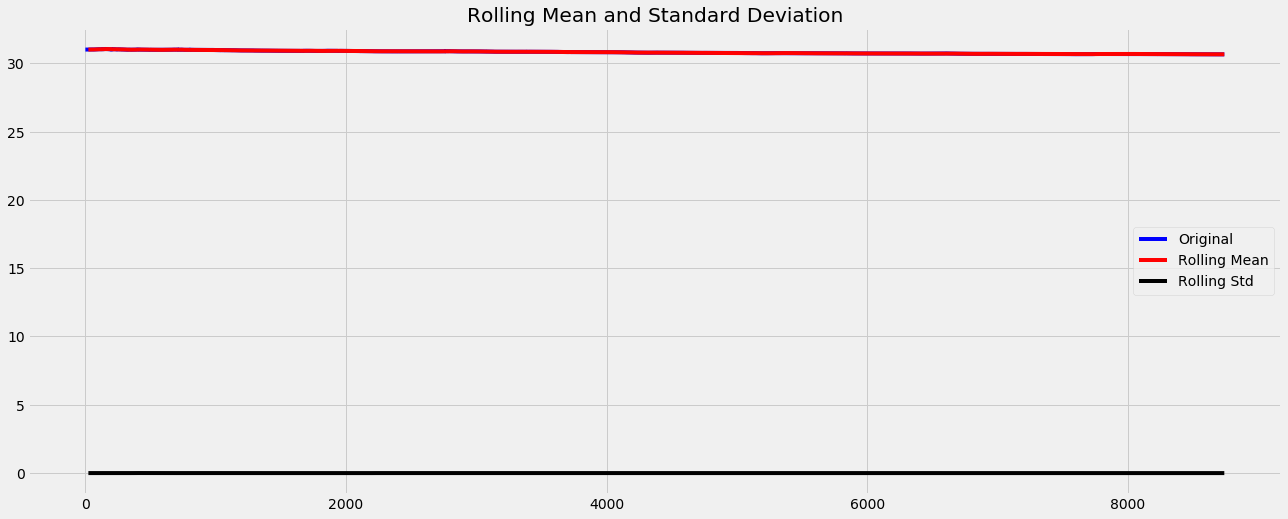

Results of dickey fuller test
Test Statistics                  -1.518328
p-value                           0.524426
No. of lags used                 27.000000
Number of observations used    8712.000000
critical value (1%)              -3.431101
critical value (5%)              -2.861872
critical value (10%)             -2.566947
dtype: float64


In [5]:
test_stationarity(hydro["Water Level"])

We see that the p-value is greater than 0.05 so we cannot reject the Null hypothesis. Also, the test statistics is greater than the critical values. so the data is non-stationary.

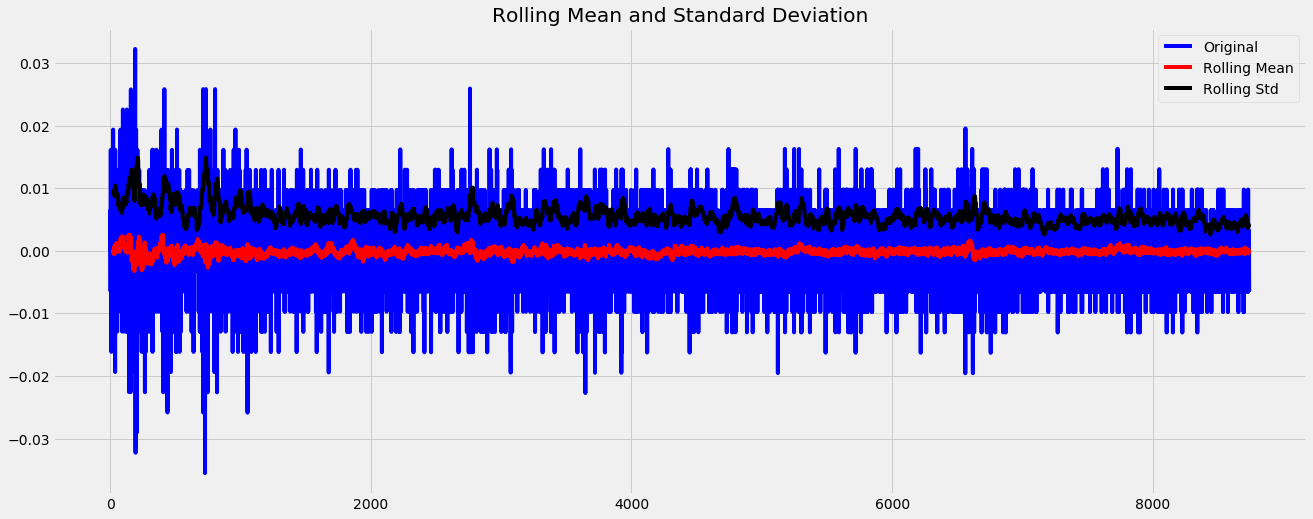

Results of dickey fuller test
Test Statistics               -1.744510e+01
p-value                        4.686084e-30
No. of lags used               2.600000e+01
Number of observations used    8.712000e+03
critical value (1%)           -3.431101e+00
critical value (5%)           -2.861872e+00
critical value (10%)          -2.566947e+00
dtype: float64


In [6]:
hydro['Water Level_previous'] = hydro["Water Level"].shift(1) 
hydro['WL_pct'] = 100*(hydro["Water Level"]  - hydro['Water Level_previous'] ) / hydro['Water Level_previous']
hydro.dropna(inplace = True)
test_stationarity(hydro['WL_pct'])

Through the above graph,The series have a constant mean and variance. and the p-value is less than 0.05 so we can reject the Null hypothesis. so the data is stationary.

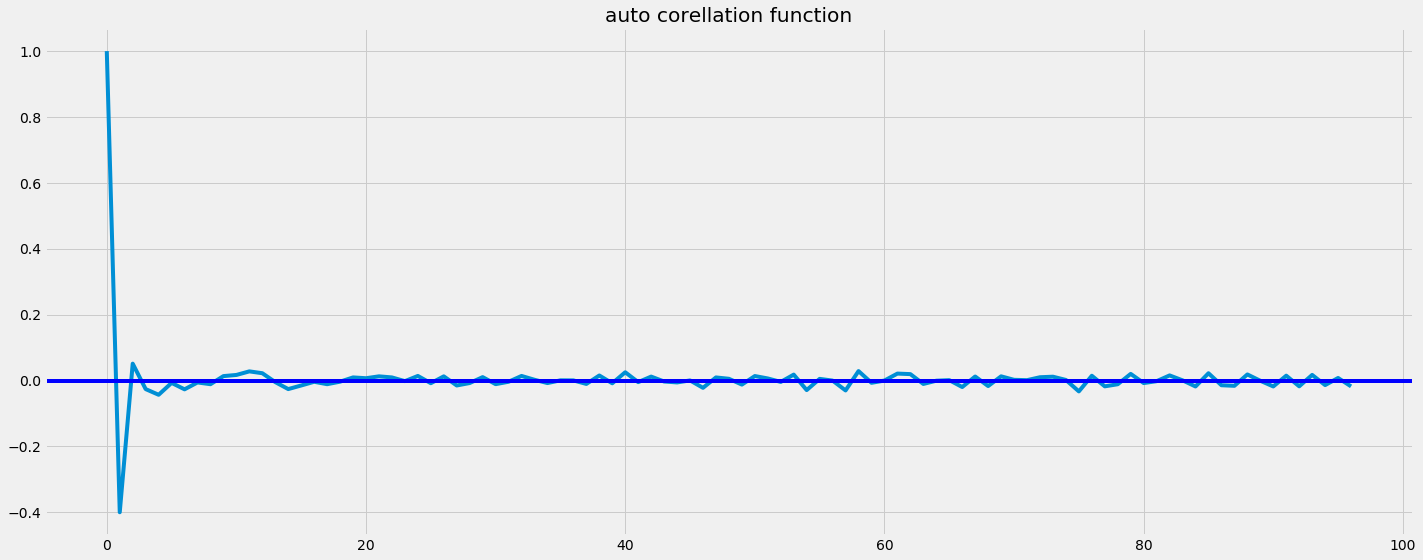

In [7]:
# we use d value here(data_log_shift)
_acf = acf(hydro['WL_pct'], nlags=96)
#plot ACF
plt.plot(_acf) 
plt.axhline(y=0,linestyle='-',color='blue')

plt.title('auto corellation function')
plt.tight_layout()

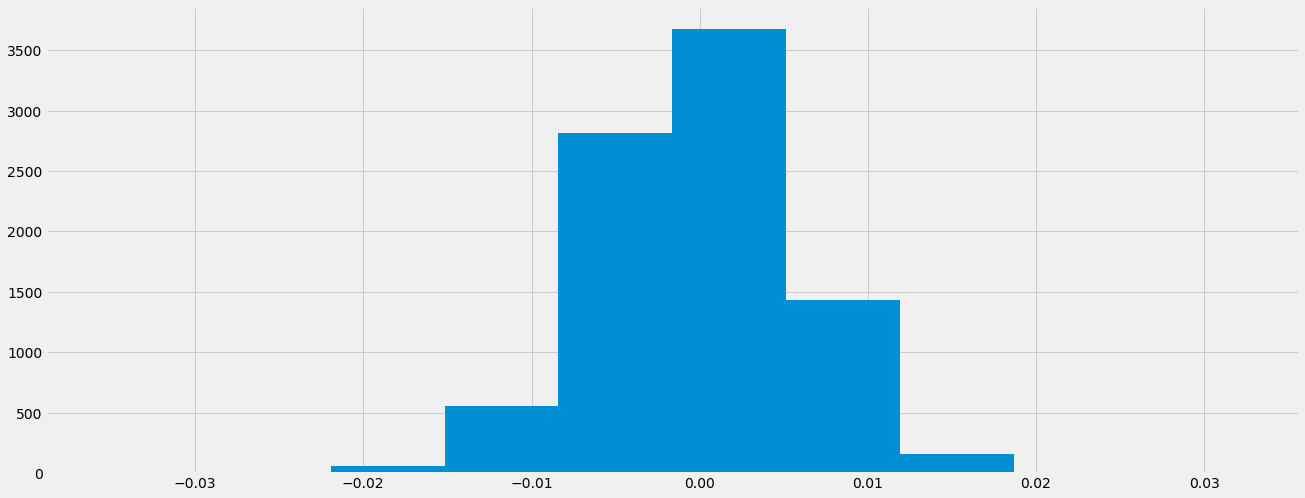

In [8]:
hydro['WL_pct'].hist()

# Anomaly detection

# Data Denoising

# Feature Engineering

## Statistical Features 

In [9]:
hydro['WL_mean_12'] = hydro['WL_pct'].rolling(12).mean()
hydro['WL_mean_18'] = hydro['WL_pct'].rolling(18).mean()
hydro['WL_mean_24'] = hydro['WL_pct'].rolling(24).mean()

hydro['WL_std_12']  = hydro['WL_pct'].rolling(12).std()
hydro['WL_std_24']  = hydro['WL_pct'].rolling(24).std()

hydro['WL_lag_12']  = hydro['WL_pct'].shift(12)
hydro['WL_lag_6']  = hydro['WL_pct'].shift(6)

hydro.dropna(inplace = True )

In [10]:
num_feat = ['WL_pct','WL_mean_12','WL_mean_18','WL_mean_18','WL_mean_24','WL_std_12','WL_std_24','WL_lag_12','WL_lag_6']

## Time Based Features 

In [11]:
hydro['hour'] = hydro['Date'].dt.hour
hydro['dayOfweek'] =  hydro['Date'].dt.dayofweek

In [12]:
cat_feat = ['hour','dayOfweek']

In [13]:
embbedded_size  = [(24,12),(7,4)]

# Modling Part 

In [14]:
seq_len = len(hydro)
train_data = hydro.iloc[:int(0.8*seq_len)] 
val_data = hydro.iloc[int(0.8*seq_len):] 

## Model 1 :  Stacked LSTM 

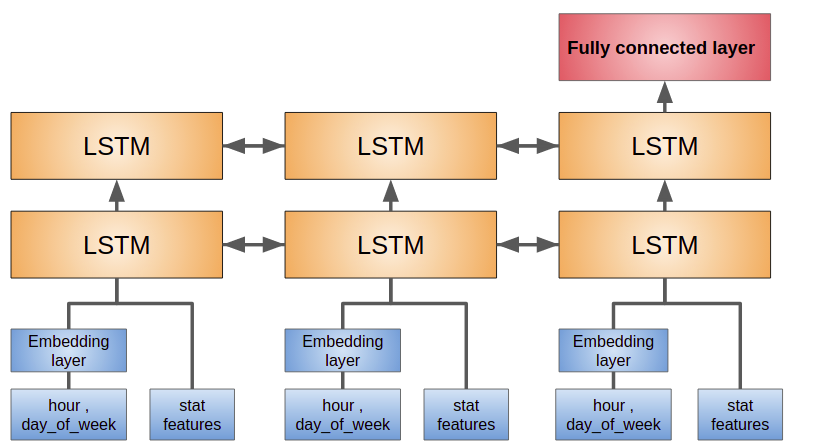

In [15]:
# Hyperparameters 
train_batch_size = 32
valid_batch_size = 16
epochs = 100
input_size = len(num_feat)
hidden_size = 32
lr = 1e-4
device = torch.device('cuda')
window_size = 24  
path = 'LSTM_Staked.pth'
verbose = False

train_dataset = hydro_dataset(train_data , window_size , num_feat , cat_feat )
valid_dataset = hydro_dataset(val_data , window_size , num_feat , cat_feat )

stacked_lstm = StackedLSTMs(input_size,hidden_size)
stacked_lstm = stacked_lstm.to(device)
val_loss, train_loss = run(
    stacked_lstm,
    train_dataset,
    valid_dataset,
    lr,
    epochs,
    train_batch_size,
    valid_batch_size,
    device,
    path,
    verbose 
)

--------- Epoch 0 ---------
 train_loss  = 9.586635625314014e-05
 val_loss  = 2.382819775448297e-05
--------- Epoch 10 ---------
 train_loss  = 2.9101635140951333e-05
 val_loss  = 1.6584630173013096e-05
--------- Epoch 20 ---------
 train_loss  = 2.7985091191771762e-05
 val_loss  = 1.635820594687916e-05
--------- Epoch 30 ---------
 train_loss  = 2.7749266015952337e-05
 val_loss  = 1.6202906113836366e-05
--------- Epoch 40 ---------
 train_loss  = 2.7669693627771216e-05
 val_loss  = 1.6223061101704338e-05
Eraly Stopping on Epoch 46
Best Loss =  1.620281161481048e-05


# Model 2 : ConvLSTM

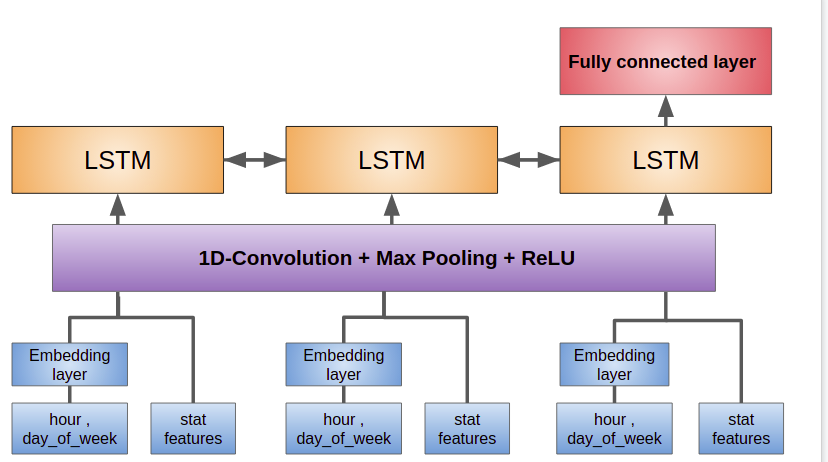

In [16]:
# Hyperparameters 
train_batch_size = 32
valid_batch_size = 16
epochs = 100
input_size = len(num_feat)
hidden_size = 32
lr = 1e-4
device = torch.device('cuda')
window_size = 24  
path = 'ConvLSTM.pth'
verbose = False

train_dataset = hydro_dataset(train_data , window_size , num_feat , cat_feat )
valid_dataset = hydro_dataset(val_data , window_size , num_feat , cat_feat )

conv_lstm = ConvLSTM(input_size,hidden_size)
conv_lstm = conv_lstm.to(device)
val_loss, train_loss = run(
    conv_lstm,
    train_dataset,
    valid_dataset,
    lr,
    epochs,
    train_batch_size,
    valid_batch_size,
    device,
    path,
    verbose 
)

--------- Epoch 0 ---------
 train_loss  = 0.010988906015973878
 val_loss  = 0.0003838801517472516
--------- Epoch 10 ---------
 train_loss  = 3.698062614978738e-05
 val_loss  = 2.400669304565613e-05
--------- Epoch 20 ---------
 train_loss  = 3.296231912877416e-05
 val_loss  = 2.1728903557568964e-05
--------- Epoch 30 ---------
 train_loss  = 3.1743829797485035e-05
 val_loss  = 1.9478775757138295e-05
--------- Epoch 40 ---------
 train_loss  = 2.9723296810257666e-05
 val_loss  = 1.8910954854281618e-05
--------- Epoch 50 ---------
 train_loss  = 2.8917892571396372e-05
 val_loss  = 1.861124157029634e-05
--------- Epoch 60 ---------
 train_loss  = 2.7874544205112273e-05
 val_loss  = 1.9122664584587995e-05
--------- Epoch 70 ---------
 train_loss  = 2.6668143948323015e-05
 val_loss  = 1.8092648617682614e-05
--------- Epoch 80 ---------
 train_loss  = 2.6405259490308434e-05
 val_loss  = 1.810962247940619e-05
Eraly Stopping on Epoch 82
Best Loss =  1.8088640642956846e-05


# Model 3 : ConvTransformer

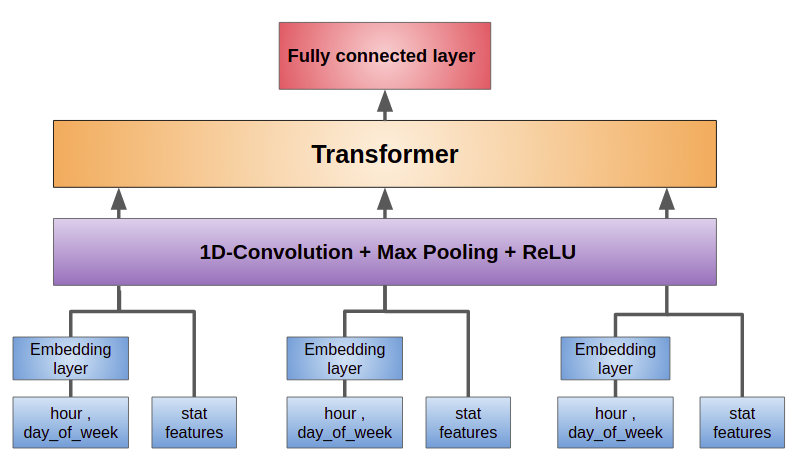

In [17]:
# Hyperparameters 
train_batch_size = 32
valid_batch_size = 16
epochs = 100
input_size = len(num_feat)
hidden_size = 32
lr = 1e-4
device = torch.device('cuda')
window_size = 24  
path = 'ConvLSTM.pth'
verbose = False

train_dataset = hydro_dataset(train_data , window_size , num_feat , cat_feat )
valid_dataset = hydro_dataset(val_data , window_size , num_feat , cat_feat )

conv_transformer = ConvTransformer(input_size,hidden_size)
conv_transformer = conv_transformer.to(device)

val_loss, train_loss = run(
    conv_transformer,
    train_dataset,
    valid_dataset,
    lr,
    epochs,
    train_batch_size,
    valid_batch_size,
    device,
    path,
    verbose 
)

--------- Epoch 0 ---------
 train_loss  = 0.0002954197034758832
 val_loss  = 5.9606696140690474e-05
--------- Epoch 10 ---------
 train_loss  = 3.8072987423353685e-05
 val_loss  = 2.6904786165215666e-05
--------- Epoch 20 ---------
 train_loss  = 3.526801503055949e-05
 val_loss  = 2.130335952575411e-05
--------- Epoch 30 ---------
 train_loss  = 3.334889586750843e-05
 val_loss  = 2.027474205432453e-05
--------- Epoch 40 ---------
 train_loss  = 3.293624718234567e-05
 val_loss  = 2.0169268037972398e-05
--------- Epoch 50 ---------
 train_loss  = 2.983205815426201e-05
 val_loss  = 1.9742474638338468e-05
Eraly Stopping on Epoch 58
Best Loss =  1.9487235257892514e-05


# Results 

In [18]:
val_data = val_data.iloc[window_size:]

pred = predict( stacked_lstm , valid_dataset )
val_data['WL_pct_hat'] = pred / 100 
val_data['WL_hat_stacked_lstm'] = val_data['Water Level_previous'] * (1+val_data['WL_pct_hat'] )

pred = predict( conv_lstm , valid_dataset )
val_data['WL_pct_hat'] = pred / 100 
val_data['WL_hat_conv_lstm'] = val_data['Water Level_previous'] * (1+val_data['WL_pct_hat'] )

pred = predict( conv_transformer , valid_dataset )
val_data['WL_pct_hat'] = pred / 100 
val_data['WL_hat_conv_transformer'] = val_data['Water Level_previous'] * (1+val_data['WL_pct_hat'] )


fig = make_subplots()
fig.add_trace(go.Scatter( y=val_data['Water Level'].values, name='Ground Truth values'))
fig.add_trace(go.Scatter( y=val_data['WL_hat_stacked_lstm'].values ,name='stacked_lstm predictions'))
fig.add_trace(go.Scatter( y=val_data['WL_hat_conv_lstm'].values ,name='conv_lstm predictions'))
fig.add_trace(go.Scatter( y=val_data['WL_hat_conv_transformer'].values ,name='conv_transformer predictions'))
fig.show()

100%|██████████| 27/27 [00:00<00:00, 71.60it/s] 


# Transfer Learning 